In [0]:
from pyspark.sql import SparkSession

# Initialize Spark session (only needed in local setups, Databricks automatically handles this)
spark = SparkSession.builder.appName("MLflow_Example").getOrCreate()

In [0]:
spark_df = spark.read.csv("dbfs:/FileStore/tables/Task.csv", header=True, inferSchema=True)
df = spark_df.toPandas()

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,AdaBoostRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error,  mean_absolute_percentage_error
import mlflow
import mlflow.sklearn
import mlflow.xgboost
mlflow.autolog(disable=True)


## Data Processing

In [0]:
columns_to_convert = df.columns[df.nunique() < 11]
df[columns_to_convert] =df[columns_to_convert].astype('category')
features_cat=['region']

df_meta_data=df.dtypes.to_dict()
df_meta_data={key: value for key, value in df_meta_data.items() if key not in features_cat}


preprocessor = ColumnTransformer(
    transformers=[
        ('Flag', OneHotEncoder(), features_cat)
    ],remainder='passthrough',verbose_feature_names_out=False)

X_encoded = preprocessor.fit_transform(df)
features_to_scale=[x for x in df_meta_data if df_meta_data[x] in ['int64','float64']]
columns_after_encoding = preprocessor.get_feature_names_out(df.columns)

df = pd.DataFrame(X_encoded, columns=columns_after_encoding)
df=df.astype(df_meta_data)

sex_map = {'male': 0, 'female': 1}
smoker_map={'no': 0, 'yes': 1}

df['sex'] = df['sex'].map(sex_map)
df['smoker']=df['smoker'].map(smoker_map)


In [0]:
X=df.iloc[:,:-1]
y=df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size = .70)

In [0]:
param_grid = {
    'max_depth': np.arange(5,21,1).tolist(),
    'min_samples_split': [round(X_train.shape[0]*0.1),round(X_train.shape[0]*0.05)],
    'min_samples_leaf': [round(X_train.shape[0]*0.01),round(X_train.shape[0]*0.025)],
    'criterion':['squared_error', 'absolute_error']
}

forest=RandomForestRegressor(n_estimators=50,random_state=42,max_features=3,n_jobs=-1)
grid_search=GridSearchCV(forest,param_grid=param_grid,cv=5, scoring="neg_mean_absolute_error",n_jobs=-1)

clf=grid_search.fit(X_train, y_train)
print(clf.best_estimator_)
print(clf.best_params_)

RandomForestRegressor(criterion='absolute_error', max_depth=7, max_features=3,
                      min_samples_leaf=9, min_samples_split=47, n_estimators=50,
                      n_jobs=-1, random_state=42)
{'criterion': 'absolute_error', 'max_depth': 7, 'min_samples_leaf': 9, 'min_samples_split': 47}


In [0]:
cv_results=pd.DataFrame(clf.cv_results_)
cv_results.sort_values(by=['rank_test_score','param_max_depth']).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
73,0.418925,0.128968,0.018498,0.005968,absolute_error,7,9,47,"{'criterion': 'absolute_error', 'max_depth': 7...",-3727.936773,-4025.576746,-3461.283715,-3312.045613,-3903.232224,-3686.015014,266.308164,1
81,0.395876,0.020766,0.035405,0.012271,absolute_error,9,9,47,"{'criterion': 'absolute_error', 'max_depth': 9...",-3761.614910,-4042.576617,-3454.048913,-3318.340844,-3877.148628,-3690.745983,267.680495,2
85,0.297532,0.015250,0.018834,0.004784,absolute_error,10,9,47,"{'criterion': 'absolute_error', 'max_depth': 1...",-3761.614910,-4042.576617,-3454.048913,-3318.340844,-3877.148628,-3690.745983,267.680495,2
89,0.312126,0.018624,0.023617,0.008108,absolute_error,11,9,47,"{'criterion': 'absolute_error', 'max_depth': 1...",-3761.614910,-4042.576617,-3454.048913,-3318.340844,-3877.148628,-3690.745983,267.680495,2
93,0.294151,0.013702,0.019018,0.003781,absolute_error,12,9,47,"{'criterion': 'absolute_error', 'max_depth': 1...",-3761.614910,-4042.576617,-3454.048913,-3318.340844,-3877.148628,-3690.745983,267.680495,2


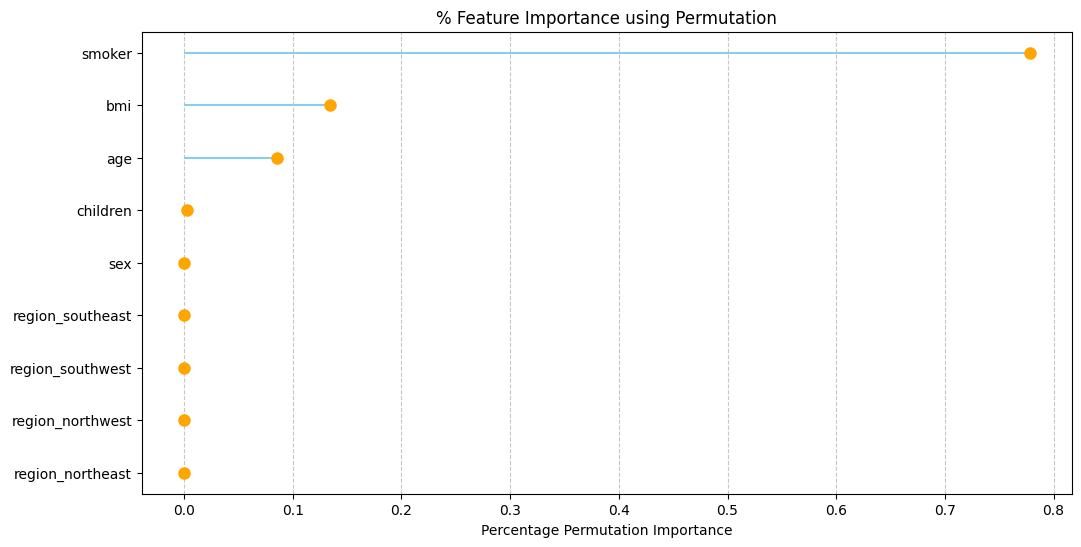

In [0]:
best_rt_params=clf.best_params_.copy()
forest=RandomForestRegressor(**best_rt_params)
forest.fit(X_train,y_train)

results = permutation_importance(forest, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = results.importances_mean.argsort()
prc=results.importances_mean/results.importances_mean.sum()

plt.figure(figsize=(12, 6)) 
plt.hlines(y=range(len(sorted_idx)), xmin=0, xmax=prc[sorted_idx], 
           color='skyblue', alpha=1)  # Draw horizontal lines
plt.plot(prc[sorted_idx], 
         range(len(sorted_idx)), "o", color='orange', markersize=8)

plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])  # Set y-ticks to feature names
plt.xlabel("Percentage Permutation Importance")
plt.title("% Feature Importance using Permutation")
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Optional grid for better readability
plt.show()

### Extra Random Trees

In [0]:
param_grid = {
    'max_depth': np.arange(5,21,1).tolist(),
    'min_samples_split': [round(X_train.shape[0]*0.1),round(X_train.shape[0]*0.05)],
    'min_samples_leaf': [round(X_train.shape[0]*0.01),round(X_train.shape[0]*0.025)],
    'criterion':['squared_error', 'absolute_error']
}

etree=ExtraTreesRegressor(n_estimators=50,random_state=42,max_features=3,n_jobs=-1)
grid_search=GridSearchCV(etree,param_grid=param_grid,cv=5, scoring="neg_mean_absolute_error",n_jobs=-1)

clf=grid_search.fit(X_train, y_train)
print(clf.best_estimator_)
print(clf.best_params_)

ExtraTreesRegressor(criterion='absolute_error', max_depth=8, max_features=3,
                    min_samples_leaf=9, min_samples_split=47, n_estimators=50,
                    n_jobs=-1, random_state=42)
{'criterion': 'absolute_error', 'max_depth': 8, 'min_samples_leaf': 9, 'min_samples_split': 47}


In [0]:
cv_results=pd.DataFrame(clf.cv_results_)
cv_results.sort_values(by=['rank_test_score','param_max_depth']).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
77,0.816423,0.023365,0.031073,0.013099,absolute_error,8,9,47,"{'criterion': 'absolute_error', 'max_depth': 8...",-4010.010613,-3995.576645,-4051.403312,-3867.904531,-4237.613485,-4032.501717,119.490294,1
81,0.824012,0.029361,0.031258,0.009416,absolute_error,9,9,47,"{'criterion': 'absolute_error', 'max_depth': 9...",-4040.136461,-4121.695739,-3957.485597,-3825.942733,-4259.981118,-4041.048329,146.757998,2
73,0.868572,0.037527,0.026046,0.009916,absolute_error,7,9,47,"{'criterion': 'absolute_error', 'max_depth': 7...",-4051.342245,-4092.286171,-4107.096068,-3783.788562,-4177.461082,-4042.394826,135.554820,3
93,0.852323,0.066946,0.019398,0.006730,absolute_error,12,9,47,"{'criterion': 'absolute_error', 'max_depth': 1...",-4094.098577,-4076.345802,-4055.350341,-3809.625672,-4242.559909,-4055.596060,139.549252,4
105,0.821895,0.042398,0.036686,0.009158,absolute_error,15,9,47,"{'criterion': 'absolute_error', 'max_depth': 1...",-4094.098577,-4076.345802,-4055.350341,-3809.625672,-4242.559909,-4055.596060,139.549252,4


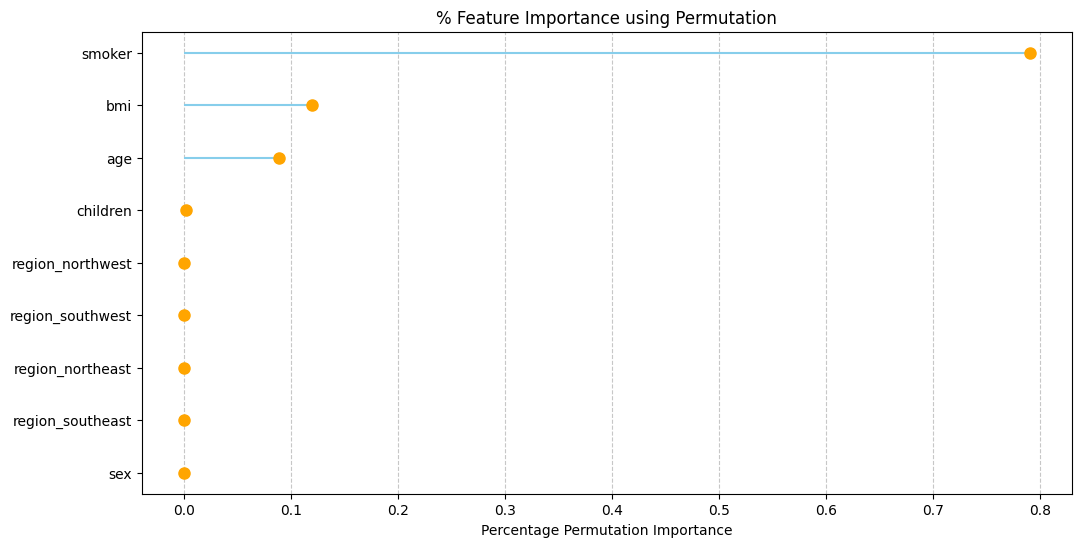

In [0]:
best_etree_params=clf.best_params_.copy()
etree=ExtraTreesRegressor(**best_etree_params)
etree.fit(X_train,y_train)

results = permutation_importance(etree, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = results.importances_mean.argsort()
prc=results.importances_mean/results.importances_mean.sum()

plt.figure(figsize=(12, 6)) 
plt.hlines(y=range(len(sorted_idx)), xmin=0, xmax=prc[sorted_idx], 
           color='skyblue', alpha=1)  
plt.plot(prc[sorted_idx], 
         range(len(sorted_idx)), "o", color='orange', markersize=8)

plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])  
plt.xlabel("Percentage Permutation Importance")
plt.title("% Feature Importance using Permutation")
plt.grid(axis='x', linestyle='--', alpha=0.7)  
plt.show()

### AdaBoost Regressor

In [0]:
param_grid = {
    'n_estimators':[10,25,50,100],
    'learning_rate': [0.1,0.3, 0.5,0.8,1]
}

ada=AdaBoostRegressor(random_state=42)
grid_search=GridSearchCV(ada,param_grid=param_grid,cv=5, scoring="neg_mean_absolute_error",n_jobs=-1)

clf=grid_search.fit(X_train, y_train)
print(clf.best_estimator_)
print(clf.best_params_)

AdaBoostRegressor(learning_rate=0.1, n_estimators=10, random_state=42)
{'learning_rate': 0.1, 'n_estimators': 10}


In [0]:
cv_results=pd.DataFrame(clf.cv_results_)
cv_results.sort_values(by=['rank_test_score']).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.052816,0.021862,0.011904,0.009139,0.1,10,"{'learning_rate': 0.1, 'n_estimators': 10}",-3044.367256,-2729.961415,-3121.093904,-3254.508679,-3547.550074,-3139.496266,267.148923,1
1,0.090180,0.020062,0.007031,0.000816,0.1,25,"{'learning_rate': 0.1, 'n_estimators': 25}",-3431.436593,-3184.217374,-3597.892644,-3736.576105,-3865.338723,-3563.092288,238.134428,2
4,0.032135,0.001411,0.006023,0.003538,0.3,10,"{'learning_rate': 0.3, 'n_estimators': 10}",-3456.203362,-3209.060144,-3520.031319,-3962.777946,-3862.032341,-3602.021022,275.737120,3
8,0.031757,0.002215,0.004275,0.000610,0.5,10,"{'learning_rate': 0.5, 'n_estimators': 10}",-3586.379059,-3578.780431,-3853.564860,-4112.190003,-3918.529504,-3809.888771,204.188198,4
12,0.029788,0.002955,0.004530,0.000770,0.8,10,"{'learning_rate': 0.8, 'n_estimators': 10}",-3704.041339,-3522.969330,-4032.360347,-4002.668143,-3995.449705,-3851.497773,202.958246,5


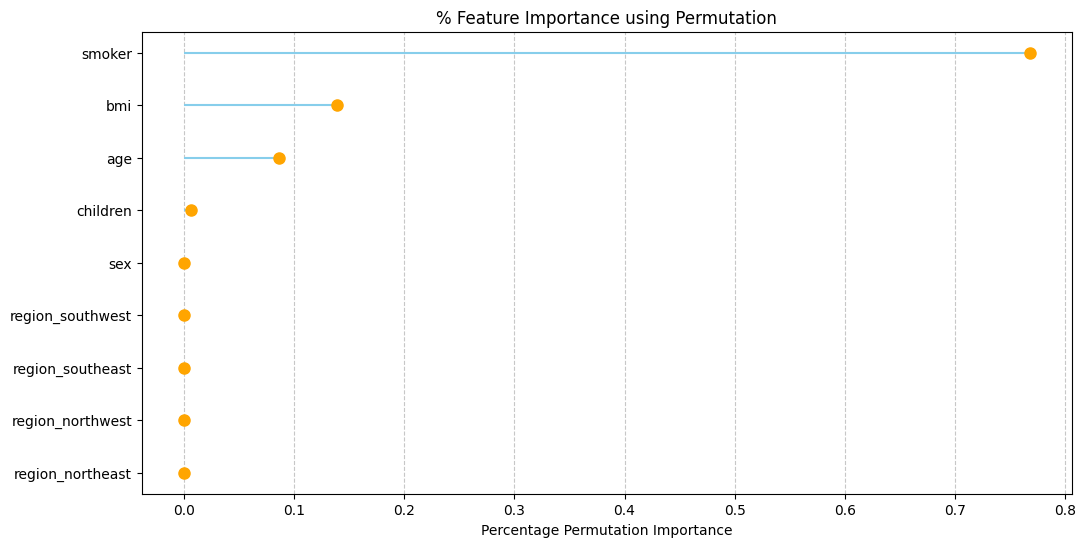

In [0]:
best_ada_params=clf.best_params_.copy()
ada=AdaBoostRegressor(**best_ada_params)
ada.fit(X_train,y_train)

results = permutation_importance(ada, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = results.importances_mean.argsort()
prc=results.importances_mean/results.importances_mean.sum()

plt.figure(figsize=(12, 6)) 
plt.hlines(y=range(len(sorted_idx)), xmin=0, xmax=prc[sorted_idx], 
           color='skyblue', alpha=1)  
plt.plot(prc[sorted_idx], 
         range(len(sorted_idx)), "o", color='orange', markersize=8)

plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])  
plt.xlabel("Percentage Permutation Importance")
plt.title("% Feature Importance using Permutation")
plt.grid(axis='x', linestyle='--', alpha=0.7)  
plt.show()

### XGBOOST

In [0]:
X_train = X_train.astype(float)
X_test = X_test.astype(float)

param_grid = {
    'n_estimators': [10,25],        
    'learning_rate': [0.1, 0.5,1.],     
    'max_depth': [5, 12],                
    'subsample': [0.8, 1.0],              
    'colsample_bytree': [0.8, 1.0],       
    'gamma': [1, 2],                  
    'reg_alpha': [0, 0.1],              
    'reg_lambda': [0.5, 1]              
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', 
                           cv=5, n_jobs=-1)

clf=grid_search.fit(X_train, y_train)
print(clf.best_estimator_)
print(clf.best_params_)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=25, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)
{'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 25, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 1.0}


In [0]:
cv_results=pd.DataFrame(clf.cv_results_)
cv_results.sort_values(by=['rank_test_score']).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_reg_alpha,param_reg_lambda,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
207,0.037959,0.014096,0.003036,0.000642,1.0,1,0.1,5,25,0.1,1,1.0,"{'colsample_bytree': 1.0, 'gamma': 1, 'learnin...",-2.127259e+07,-1.911663e+07,-2.786410e+07,-2.732686e+07,-2.759775e+07,-2.463559e+07,3.693489e+06,1
303,0.042693,0.007318,0.008141,0.002644,1.0,2,0.1,5,25,0.1,1,1.0,"{'colsample_bytree': 1.0, 'gamma': 2, 'learnin...",-2.127259e+07,-1.911663e+07,-2.786410e+07,-2.732686e+07,-2.759775e+07,-2.463559e+07,3.693489e+06,1
299,0.030392,0.000834,0.002678,0.000434,1.0,2,0.1,5,25,0,1,1.0,"{'colsample_bytree': 1.0, 'gamma': 2, 'learnin...",-2.127259e+07,-1.917423e+07,-2.786409e+07,-2.732686e+07,-2.759775e+07,-2.464710e+07,3.676304e+06,3
203,0.030036,0.000821,0.002489,0.000441,1.0,1,0.1,5,25,0,1,1.0,"{'colsample_bytree': 1.0, 'gamma': 1, 'learnin...",-2.127259e+07,-1.917423e+07,-2.786409e+07,-2.732686e+07,-2.759775e+07,-2.464710e+07,3.676304e+06,3
298,0.032119,0.001420,0.002603,0.000599,1.0,2,0.1,5,25,0,1,0.8,"{'colsample_bytree': 1.0, 'gamma': 2, 'learnin...",-2.179038e+07,-1.930035e+07,-2.809848e+07,-2.655495e+07,-2.757986e+07,-2.466480e+07,3.489985e+06,5


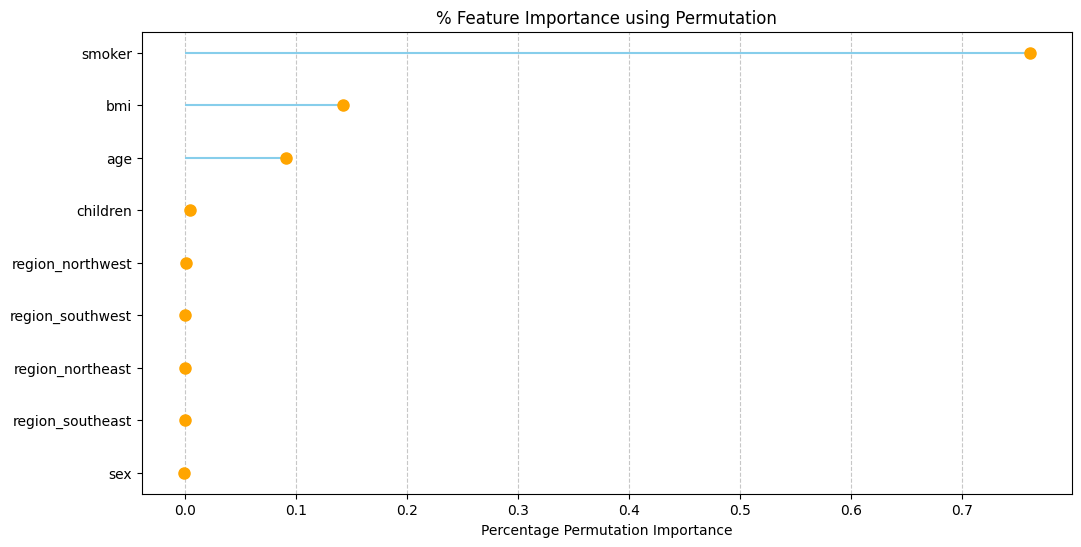

In [0]:
best_xgb_params=clf.best_params_.copy()
xgb_model=xgb.XGBRegressor(**best_xgb_params)
xgb_model.fit(X_train,y_train)

results = permutation_importance(xgb_model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = results.importances_mean.argsort()
prc=results.importances_mean/results.importances_mean.sum()

plt.figure(figsize=(12, 6)) 
plt.hlines(y=range(len(sorted_idx)), xmin=0, xmax=prc[sorted_idx], 
           color='skyblue', alpha=1)  
plt.plot(prc[sorted_idx], 
         range(len(sorted_idx)), "o", color='orange', markersize=8)

plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])  
plt.xlabel("Percentage Permutation Importance")
plt.title("% Feature Importance using Permutation")
plt.grid(axis='x', linestyle='--', alpha=0.7)  
plt.show()

## MLflow implementation

In [0]:

def evaluation_metrics(y_true,y_pred):
  mae=mean_absolute_error(y_true, y_pred)
  mse=mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  mape=mean_absolute_percentage_error(y_true, y_pred)
  return {'MAE':mae,'MSE':mse,'RMSE':rmse,'MAPE':mape}


In [0]:
models = [
    (
        "Random Forest", 
        RandomForestRegressor(), 
        best_rt_params,
        (X_train, y_train),
        (X_test, y_test)
    ),
    (
        "Extra Random Trees", 
        ExtraTreesRegressor(), 
        best_etree_params,
        (X_train, y_train),
        (X_test, y_test)
    ),
    (
        "Adaboost",
        AdaBoostRegressor(),
        best_ada_params,
        (X_train, y_train),
        (X_test, y_test)
    ),
    (
        "XGBoost",
        xgb.XGBRegressor(), 
        best_xgb_params,
        (X_train, y_train),
        (X_test, y_test)
    )
]

In [0]:
reports = []

for model_name, model, params, train_partition, test_partition in models:
    X_train = train_partition[0]
    y_train = train_partition[1]
    X_test = test_partition[0]
    y_test = test_partition[1]
    
    model.set_params(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = evaluation_metrics(y_pred,y_test)
    reports.append(report)

reports

[{'MAE': 1903.8726421767415,
  'MSE': 20312050.959556196,
  'RMSE': 4506.889277490207,
  'MAPE': 0.2829703969722708},
 {'MAE': 1862.4054638538541,
  'MSE': 20091202.14910878,
  'RMSE': 4482.32106716027,
  'MAPE': 0.28828569199045734},
 {'MAE': 3115.8827318181584,
  'MSE': 23078811.537437636,
  'RMSE': 4804.041167333772,
  'MAPE': 0.35783865011865684},
 {'MAE': 2160.685936662527,
  'MSE': 19559711.870723553,
  'RMSE': 4422.636303238551,
  'MAPE': 0.30031935002269594}]

In [0]:
mlflow.set_experiment(experiment_id='your_experiment_id')

for i, element in enumerate(models):
  model_name=element[0]
  model=element[1]
  param=element[2]
  metric=reports[i]
  

  with mlflow.start_run(run_name=model_name):

    mlflow.log_param('model',model_name)
    mlflow.log_metric('MAE', metric['MAE'])
    mlflow.log_metric('MSE', metric['MSE'])
    mlflow.log_metric('RMSE', metric['RMSE'])
    mlflow.log_metric('MAPE', metric['MAPE'])

    if 'XGB' in model_name:
      mlflow.xgboost.log_model(model,'model')
    else:
      mlflow.sklearn.log_model(model,'model')